In [ ]:
!pip install pydicom
!pip install git+https://github.com/facebookresearch/fvcore.git
!pip install torchsummary

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-eccc0vzc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-eccc0vzc
  Resolved https://github.com/facebookresearch/fvcore.git to commit d051804c97dfd7c8f349996fefd8644fe2955bc2
  Preparing metadata (setup.py) ... done


In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
import logging
import warnings
import random
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchsummary import summary
from tqdm import tqdm

In [ ]:
pydicom_logger = logging.getLogger("pydicom")
pydicom_logger.setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning, module="pydicom")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class ISPY1Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.subjects = sorted(os.listdir(root_dir))
        self.transform = transform

    def __len__(self):
        return len(self.subjects) * 4

    def load_dicom_images(self, dicom_dir):
        slices = [pydicom.dcmread(os.path.join(dicom_dir, f)) for f in os.listdir(dicom_dir)]
        slices_array = np.stack([s.pixel_array for s in slices], axis=0)
        return slices_array.astype(np.float32) / np.max(slices_array)

    def __getitem__(self, idx):
        subject_idx = idx // 4
        sample_type = idx % 4

        subject_path = os.path.join(self.root_dir, self.subjects[subject_idx])
        time_stages = ['T1', 'T2', 'T3', 'T4']
        correct_order = []

        for stage in time_stages:
            dicom_dir = os.path.join(subject_path, stage)
            image_stack = self.load_dicom_images(dicom_dir)
            resized_stack = np.stack([
                F.resize(torch.tensor(slice)[None, ...], (256, 256)).squeeze(0)
                for slice in image_stack
            ], axis=0)
            correct_order.append(resized_stack)

        if sample_type == 0:
            # Correct order sample
            shuffled_order = correct_order
            label = 1
        else:
            # Shuffled order sample
            shuffled_order = correct_order.copy()
            random.shuffle(shuffled_order)
            label = 0

        sample = np.stack(shuffled_order, axis=0)
        if self.transform:
            sample = self.transform(sample)

        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [ ]:
dataset = ISPY1Dataset(root_dir='/content/drive/MyDrive/ISPY1_sub')
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

In [ ]:
model = torch.hub.load('facebookresearch/pytorchvideo', 'slow_r50', pretrained=False)
model.blocks[0].conv = nn.Conv3d(
    in_channels=4,
    out_channels=model.blocks[0].conv.out_channels,
    kernel_size=model.blocks[0].conv.kernel_size,
    stride=model.blocks[0].conv.stride,
    padding=model.blocks[0].conv.padding,
    bias=model.blocks[0].conv.bias is not None
)
model.blocks[5].proj = nn.Sequential(
    nn.Linear(in_features=2048, out_features=512, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=128, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=2, bias=True)  # Output layer
)
model = model.to(device)
summary(model, input_size=(4, 60, 256, 256), device=str(device))

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 64, 60, 128, 128]          12,544
       BatchNorm3d-2     [-1, 64, 60, 128, 128]             128
              ReLU-3     [-1, 64, 60, 128, 128]               0
         MaxPool3d-4       [-1, 64, 60, 64, 64]               0
   ResNetBasicStem-5       [-1, 64, 60, 64, 64]               0
            Conv3d-6      [-1, 256, 60, 64, 64]          16,384
       BatchNorm3d-7      [-1, 256, 60, 64, 64]             512
            Conv3d-8       [-1, 64, 60, 64, 64]           4,096
       BatchNorm3d-9       [-1, 64, 60, 64, 64]             128
             ReLU-10       [-1, 64, 60, 64, 64]               0
           Conv3d-11       [-1, 64, 60, 64, 64]          36,864
      BatchNorm3d-12       [-1, 64, 60, 64, 64]             128
             ReLU-13       [-1, 64, 60, 64, 64]               0
           Conv3d-14      [-1, 256, 60,

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50
losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}')
    losses.append(running_loss/len(dataloader))

100%|██████████| 81/81 [07:48<00:00,  5.78s/it]


Epoch 1, Loss: 0.5783255825072159


100%|██████████| 81/81 [07:45<00:00,  5.75s/it]


Epoch 2, Loss: 0.5674501206771827


100%|██████████| 81/81 [07:45<00:00,  5.75s/it]


Epoch 3, Loss: 0.5668672623089802


100%|██████████| 81/81 [07:48<00:00,  5.78s/it]


Epoch 4, Loss: 0.5606213423572941


100%|██████████| 81/81 [07:46<00:00,  5.76s/it]


Epoch 5, Loss: 0.5505164758658704


100%|██████████| 81/81 [07:46<00:00,  5.76s/it]


Epoch 6, Loss: 0.5539119263857971


100%|██████████| 81/81 [07:48<00:00,  5.78s/it]


Epoch 7, Loss: 0.5450946543319726


100%|██████████| 81/81 [07:45<00:00,  5.75s/it]


Epoch 8, Loss: 0.545534755344744


100%|██████████| 81/81 [07:48<00:00,  5.79s/it]


Epoch 9, Loss: 0.543512354110494


100%|██████████| 81/81 [07:42<00:00,  5.71s/it]


Epoch 10, Loss: 0.5316326406634884


100%|██████████| 81/81 [07:44<00:00,  5.74s/it]


Epoch 11, Loss: 0.5413307909980233


100%|██████████| 81/81 [07:42<00:00,  5.70s/it]


Epoch 12, Loss: 0.541550561417768


100%|██████████| 81/81 [07:45<00:00,  5.75s/it]


Epoch 13, Loss: 0.5399465566432035


100%|██████████| 81/81 [07:42<00:00,  5.71s/it]


Epoch 14, Loss: 0.5355059539462314


100%|██████████| 81/81 [07:41<00:00,  5.70s/it]


Epoch 15, Loss: 0.5359849300649431


100%|██████████| 81/81 [07:46<00:00,  5.75s/it]


Epoch 16, Loss: 0.5316350655055341


100%|██████████| 81/81 [07:42<00:00,  5.70s/it]


Epoch 17, Loss: 0.5229096116475117


100%|██████████| 81/81 [07:43<00:00,  5.72s/it]


Epoch 18, Loss: 0.5380469810815505


100%|██████████| 81/81 [07:43<00:00,  5.72s/it]


Epoch 19, Loss: 0.5355972737809758


100%|██████████| 81/81 [07:42<00:00,  5.71s/it]


Epoch 20, Loss: 0.5228716959188013


100%|██████████| 81/81 [07:43<00:00,  5.73s/it]


Epoch 21, Loss: 0.5118329388859831


100%|██████████| 81/81 [07:44<00:00,  5.73s/it]


Epoch 22, Loss: 0.5245180832751003


100%|██████████| 81/81 [07:46<00:00,  5.76s/it]


Epoch 23, Loss: 0.49279875335869966


100%|██████████| 81/81 [07:42<00:00,  5.71s/it]


Epoch 24, Loss: 0.5056404101627844


100%|██████████| 81/81 [07:43<00:00,  5.72s/it]


Epoch 25, Loss: 0.4836784380453604


100%|██████████| 81/81 [07:42<00:00,  5.71s/it]


Epoch 26, Loss: 0.5105557141848552


100%|██████████| 81/81 [07:43<00:00,  5.72s/it]


Epoch 27, Loss: 0.455164733124368


100%|██████████| 81/81 [07:45<00:00,  5.75s/it]


Epoch 28, Loss: 0.44922091048440815


100%|██████████| 81/81 [07:45<00:00,  5.75s/it]


Epoch 29, Loss: 0.4489840418100357


100%|██████████| 81/81 [07:41<00:00,  5.70s/it]


Epoch 30, Loss: 0.4165271172920863


100%|██████████| 81/81 [07:43<00:00,  5.72s/it]


Epoch 31, Loss: 0.4493819245217759


100%|██████████| 81/81 [07:42<00:00,  5.71s/it]


Epoch 32, Loss: 0.42571720683280334


100%|██████████| 81/81 [07:44<00:00,  5.74s/it]


Epoch 33, Loss: 0.37564361766900545


100%|██████████| 81/81 [07:43<00:00,  5.73s/it]


Epoch 34, Loss: 0.3686018410932135


100%|██████████| 81/81 [07:43<00:00,  5.72s/it]


Epoch 35, Loss: 0.33362867177268607


100%|██████████| 81/81 [07:43<00:00,  5.72s/it]


Epoch 36, Loss: 0.36459656878386015


100%|██████████| 81/81 [07:42<00:00,  5.71s/it]


Epoch 37, Loss: 0.301284362366538


100%|██████████| 81/81 [07:43<00:00,  5.73s/it]


Epoch 38, Loss: 0.32241285196792935


100%|██████████| 81/81 [07:41<00:00,  5.69s/it]


Epoch 39, Loss: 0.2693212190068062


100%|██████████| 81/81 [07:52<00:00,  5.84s/it]


Epoch 40, Loss: 0.2658446998691853


100%|██████████| 81/81 [07:46<00:00,  5.76s/it]


Epoch 41, Loss: 0.25078773673301863


100%|██████████| 81/81 [07:43<00:00,  5.72s/it]


Epoch 42, Loss: 0.2543620157377495


100%|██████████| 81/81 [07:41<00:00,  5.70s/it]


Epoch 43, Loss: 0.24797951262789192


100%|██████████| 81/81 [07:41<00:00,  5.70s/it]


Epoch 44, Loss: 0.22532336807085407


100%|██████████| 81/81 [07:44<00:00,  5.74s/it]


Epoch 45, Loss: 0.24938883197804293


100%|██████████| 81/81 [07:40<00:00,  5.69s/it]


Epoch 46, Loss: 0.18204446648029082


100%|██████████| 81/81 [07:43<00:00,  5.72s/it]


Epoch 47, Loss: 0.1808526726083163


100%|██████████| 81/81 [07:42<00:00,  5.71s/it]


Epoch 48, Loss: 0.21255058212849645


100%|██████████| 81/81 [07:42<00:00,  5.71s/it]


Epoch 49, Loss: 0.26539196218881345


100%|██████████| 81/81 [07:43<00:00,  5.72s/it]

Epoch 50, Loss: 0.2609709584970533


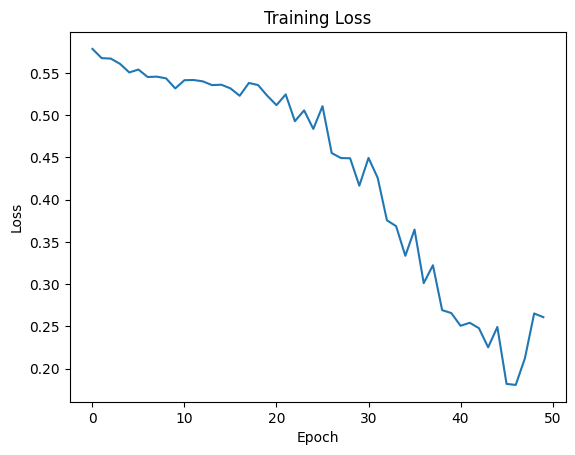

In [9]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [10]:
save_path = '/content/drive/MyDrive/model_binaryClassfication.pth'
torch.save(model.state_dict(), save_path)